In [2]:
from collections import defaultdict
from array import array
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import math
import numpy as np
import collections
from numpy import linalg as la
import time
import nltk
import pandas as pd
import re
import warnings

In [11]:
#from google.colab import drive
#drive.mount('/content/drive')

# Functions and modules

### Data cleaning functions

In [101]:
def from_json_to_dataframe(doc_path = '../data/Rus_Ukr_war_data.json'):
    with open(doc_path) as fp:
        lines = fp.readlines()
    df=pd.read_json(doc_path, lines=True)
    return df


def clean_raw_dataset(raw_df):
    # Select only relevant columns
    clean_df = raw_df[["created_at","id","full_text","entities","favorite_count","retweet_count","user"]]

    # Rename columns
    renames = {"created_at":"date", "full_text":"tweet", "favorite_count":"likes","retweet_count":"retweets", "id":"tweet_id"}
    clean_df = clean_df.rename(columns=renames)

    # Create Series of list of hashtags from `entities` object
    df_hashtags = pd.json_normalize(clean_df["entities"])["hashtags"]
    df_hashtags = df_hashtags.apply(lambda x: [item["text"] for item in x])

    # Create Series of username ids
    df_user = pd.json_normalize(clean_df["user"])["id"].rename("user_id")

    # Merge hashtags and username columns to the DataFrame
    clean_df = pd.concat([clean_df,df_hashtags,df_user], axis=1).drop(columns=["entities","user"])

    # Create URL column manually from the user id and tweet id columns
    clean_df["url"] = "https://twitter.com/" + clean_df["user_id"].astype(str) + "/status/" + clean_df["tweet_id"].astype(str)

    # Extract tags to other users from the tweet body
    clean_df["tags"] = clean_df["tweet"].apply(lambda x: re.findall(r"@(\w+)", x))

    # Returns a DataFrame of tweets with columns ["date", "tweet_id", "tweet", "likes", "retweets", "hashtags", "user_id", "url", "tags", "tags"]
    return clean_df


def remove_emojis(tweet):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emojis
                           u"\U0001F300-\U0001F5FF"  # symbols & pictograms
                           u"\U0001F680-\U0001F6FF"  # map symbols
                           u"\U0001F1E0-\U0001F1FF"  # Flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)

    return emoji_pattern.sub(r'', tweet)


def clean_tweet(line):
    
    stemmer = PorterStemmer()
    stop_words = set(stopwords.words("english"))
    ## START CODE
    line = re.sub(r'[.,;:!?"\'-@]', '', line).replace("#", "").replace("’", "").replace("“", "").replace("\n"," ")
    line =  line.lower() ## Transform in lowercase
    line = remove_emojis(line).strip().replace("  ", " ")
    line = line.split(" ") ## Tokenize the text to get a list of terms
    line =[word for word in line if word not in stop_words]  ## eliminate the stopwords (HINT: use List Comprehension)
    line =[stemmer.stem(word) for word in line] ## perform stemming (HINT: use List Comprehension)
    line = [word for word in line if word != ""]
    ## END CODE
    
    return line


def process_text_column(column):
    column = column.apply(clean_tweet)
    return column

def join_docs_tweets_dfs(tweets, csv_file='../data/Rus_Ukr_war_data_ids.csv'):
    docs = pd.read_csv(csv_file, sep="\t", header=None)
    docs = docs.rename(columns={0:"doc_id",1:"tweet_id"})
    tweets = tweets.join(docs.set_index('tweet_id'), on='tweet_id')
    return tweets

### Indexing

In [44]:
class InvertedIndex():

    def __init__(self, ids, stemmed_text):
        
        self.index = defaultdict(list)

        stemmed_text = stemmed_text.tolist()
        ids = ids.tolist()

        for i in range(len(ids)):

            tweet = stemmed_text[i]
            tweet_id = ids[i]

            terms = [word for word in tweet]
            page_id = int(tweet_id)

            current_page_index = {}

            for position, term in enumerate(terms):
                try:
                    current_page_index[term][1].append(position)
                except:
                    current_page_index[term] = [page_id, array('I', [position])]

            for term_page, posting_page in current_page_index.items():
                self.index[term_page].append(posting_page)


    def search(self, query):

        query = clean_tweet(query)
        docs = set()
        for term in query:
            try:
                term_docs = [posting[0] for posting in self.index[term]]
                term_docs = set(term_docs)
                if len(docs)==0:
                    docs = docs.union(term_docs)
                else:
                    docs = docs.intersection(term_docs)
            except:
                pass
        docs = list(docs)
        return docs




class TfIdfIndex():

    def __init__(self, ids, stemmed_text, num_documents):
        
        self.index = defaultdict(list)
        self.tf = defaultdict(list)
        self.df = defaultdict(int)
        self.idf = defaultdict(float)

        stemmed_text = stemmed_text.tolist()
        ids = ids.tolist()

        for i in range(len(ids)):

            tweet = stemmed_text[i]
            tweet_id = ids[i]

            terms = [word for word in tweet]
            page_id = int(tweet_id)

            current_page_index = {}

            for position, term in enumerate(terms):
                try:
                    current_page_index[term][1].append(position)
                except:
                    current_page_index[term] = [page_id, array('I', [position])]

            norm = 0
            for term, posting in current_page_index.items():
                norm += len(posting[1]) ** 2
            norm = math.sqrt(norm)

            for term, posting in current_page_index.items():
                self.tf[term].append(np.round(len(posting[1]) / norm, 4))
                self.df[term] += 1

            for term_page, posting_page in current_page_index.items():
                self.index[term_page].append(posting_page)

            for term in self.df:
                self.idf[term] = np.round(np.log(float(num_documents / self.df[term])), 4)


    def rank(self, stemmed_query, unranked_results):
                                          
        doc_vectors = defaultdict(lambda: [0] * len(stemmed_query))
        query_vector = [0] * len(stemmed_query)

        # compute the norm for the query tf
        query_terms_count = collections.Counter(stemmed_query)  # get the frequency of each term in the query.
        # Example: collections.Counter(["hello","hello","world"]) --> Counter({'hello': 2, 'world': 1})

        query_norm = la.norm(list(query_terms_count.values()))

        for termIndex, term in enumerate(stemmed_query):  #termIndex is the index of the term in the query
            if term not in self.index:
                continue

            # TODO: check how to vectorize the query
            # query_vector[termIndex]=idf[term]  # original
            ## Compute tf*idf(normalize TF as done with documents)
            query_vector[termIndex] = query_terms_count[term] / query_norm * self.idf[term]

            # Generate doc_vectors for matching docs
            for doc_index, (doc, postings) in enumerate(self.index[term]):
                # Example of [doc_index, (doc, postings)]
                # 0 (26, array('I', [1, 4, 12, 15, 22, 28, 32, 43, 51, 68, 333, 337]))
                # 1 (33, array('I', [26, 33, 57, 71, 87, 104, 109]))
                # term is in doc 26 in positions 1,4, .....
                # term is in doc 33 in positions 26,33, .....

                #tf[term][0] will contain the tf of the term "term" in the doc 26
                if doc in unranked_results:
                    doc_vectors[doc][termIndex] = self.tf[term][doc_index] * self.idf[term] 

        # Calculate the score of each doc
        # compute the cosine similarity between queyVector and each docVector:
        # HINT: you can use the dot product because in case of normalized vectors it corresponds to the cosine similarity
        # see np.dot

        doc_scores = [[np.dot(curDocVec, query_vector), doc] for doc, curDocVec in doc_vectors.items()]
        doc_scores.sort(reverse=True)
        #print(doc_scores)
        result_docs = [x[1] for x in doc_scores]
        #print document titles instead if document id's
        #result_docs=[ title_index[x] for x in result_docs ]

        return result_docs
                                          
    def search(self, query):

        query = clean_tweet(query)
        docs = set()
        for term in query:
            try:
                # store in term_docs the ids of the docs that contain "term"
                term_docs = set([posting[0] for posting in self.index[term]])
                                          
                # retain all documents which contain all words from the query
                if len(docs)==0:
                    docs = docs.union(term_docs)
                else:
                    docs = docs.intersection(term_docs)
            except:
                #term is not in index
                pass
        docs = list(docs) #docs are the unranked results
                                          
        ranked_docs = self.rank(query, docs)

        return ranked_docs

# 1. Indexing

In [102]:
doc_path = '../data/Rus_Ukr_war_data.json'
csv_path = '../data/Rus_Ukr_war_data_ids.csv'

# Import from JSON file
raw_df = from_json_to_dataframe(doc_path)

# Clean raw DataFrame to have a more convenient structure
clean_df = clean_raw_dataset(raw_df)

# 
clean_df["stemmed_tweet"] = process_text_column(clean_df["tweet"])


clean_df = join_docs_tweets_dfs(clean_df, csv_path)


print("Total number of Tweets in the corpus: {}".format(len(clean_df)))
clean_df.head()

Total number of Tweets in the corpus: 4000


,date,tweet_id,tweet,likes,retweets,hashtags,user_id,url,tags,stemmed_tweet,doc_id
0,2022-09-30 18:39:17+00:00,1575918221013979136,@MelSimmonsFCDO Wrong. Dictator Putin's Fascis...,0,0,"[RussiainvadesUkraine, UkraineRussiaWar]",1404526426330701825,https://twitter.com/1404526426330701825/status...,[MelSimmonsFCDO],"[melsimmonsfcdo, wrong, dictat, putin, fascist...",doc_1
1,2022-09-30 18:38:44+00:00,1575918081461080065,🇺🇦❤️ The Armed Forces liberated the village of...,0,0,"[Drobysheve, Lymansk, Donetsk, UkraineRussiaWa...",1257116113898536961,https://twitter.com/1257116113898536961/status...,[],"[arm, forc, liber, villag, drobyshev, lymansk,...",doc_2
2,2022-09-30 18:38:23+00:00,1575917992390823936,ALERT 🚨Poland preps anti-radiation tablets ove...,0,0,"[NATO, Putin, Russia, RussiaInvadedUkraine, Uk...",1460003892415053828,https://twitter.com/1460003892415053828/status...,[],"[alert, poland, prep, antiradi, tablet, nuclea...",doc_3
3,2022-09-30 18:38:03+00:00,1575917907774967809,I’m still waiting for my google map 🗺️ to upda...,0,0,"[Putin, UkraineRussiaWar]",285766081,https://twitter.com/285766081/status/157591790...,[],"[im, still, wait, googl, map, updat, russia, n...",doc_4
4,2022-09-30 18:37:56+00:00,1575917878410301441,@EmmanuelMacron probably you're right or you h...,0,0,"[European, UkraineRussiaWar]",1537193346107686915,https://twitter.com/1537193346107686915/status...,[EmmanuelMacron],"[emmanuelmacron, probabl, your, right, say, an...",doc_5


In [46]:
inverted_index = InvertedIndex(ids=clean_df["tweet_id"], stemmed_text = clean_df["stemmed_tweet"])

In [61]:
print("Insert your query:\n")
query = input()
print("Query:", query)
results = inverted_index.search(query)
top = 10

print("\n======================\nSample of {} results out of {} for the searched query:\n".format(top, len(results)))
for d_id in results[:top]:
    print("tweet_id = {}\ntweet = {}".format(d_id, clean_df[clean_df["tweet_id"]==d_id]["tweet"].item()))
    print("\n\n-------------------------------------------------------------------------------------------\n\n")

Insert your query:

Query: territories annexation russia

Sample of 10 results out of 46 for the searched query:

tweet_id = 1575913861957369856
tweet = Caitlin Johnstone: At the risk of upsetting the entire internet, the annexation of those 4 Ukrainian territories seems like a great time to end this war
https://t.co/x4K6ov9gH4

Ukraine - 4 Oblasts Join Russia
https://t.co/F8jeL2p4XF
#UkraineWar #UkraineRussiaWar #StopWar https://t.co/Nytr44kJcl


-------------------------------------------------------------------------------------------


tweet_id = 1575917907774967809
tweet = I’m still waiting for my google map 🗺️ to update Russia 🇷🇺 new annexed territory but it’s taking a bit longer than I thought 🤔 #Putin #UkraineRussiaWar


-------------------------------------------------------------------------------------------


tweet_id = 1575913773818605568
tweet = If Western nations are dismissing the referendums, why is #Russia annexing occupied Ukrainian territories? https://t.co/c9Rp5u1F

In [48]:
# Execute after implementing TFIDF INDEX

num_tweets = len(clean_df)
tf_idf_index = TfIdfIndex(ids=clean_df["tweet_id"], stemmed_text = clean_df["stemmed_tweet"], num_documents=num_tweets)

In [83]:
# Also execute after having implemented TFIDF INDEX

print("Insert your query:\n")
query = input()
print("Query:", query)

results = tf_idf_index.search(query)
top = 10

print("\n======================\nSample of {} results out of {} for the searched query:\n".format(min(len(results), top), len(results)))
for d_id in results[:top]:
    print("tweet_id= {}\ntweet: {}".format(d_id, clean_df[clean_df["tweet_id"]==d_id]["tweet"].item()))
    print("\n\n-------------------------------------------------------------------------------------------\n\n")

Insert your query:

Query: kill putin

Sample of 10 results out of 17 for the searched query:

tweet_id= 1575269385475952640
tweet: #UkraineRussiaWar #Ukraine #Russia

🌐 Social media
Comment:It's not about killing russians. It's about living in a free democratic world. About the fight of Ukraine to protect its sovereignty and independency. Russians must understand that #putin is manipulating and killing them https://t.co/z4S1KFvbJg


-------------------------------------------------------------------------------------------


tweet_id= 1575904420633939968
tweet: #UkraineWar #Ukraine #Russia #ukrainerussiawar #Putin #SanktionengegendieUSA #MAGA #俄罗斯 #乌克兰 #中國

Tears in Kadyrov's eyes. After a minute of silence in memory of those killed in Donbass

 https://t.co/Rfjil6EHo2


-------------------------------------------------------------------------------------------


tweet_id= 1575798982735204352
tweet: LIVE: Attack on Ukraine civilian convoy kills 23 ahead of Putin annexation speech
http

# 2. Evaluation

In [103]:
evaluation_df = pd.read_csv("../data/Evaluation_gt.csv")

evaluation_df.head()

,doc,query_id,label
0,doc_1452,Q3,1
1,doc_2908,Q3,1
2,doc_618,Q3,1
3,doc_489,Q3,1
4,doc_110,Q3,1


In [104]:
QUERY1 = "tank Kharkiv" # What is the discussion regarding a tank in Kharkiv?
QUERY2 = "nord stream" # What discussion are there about the Nord Stream pipeline?
QUERY3 = "territories annexation russia" # What is being said about the annexation of territories in Russia?

QUERY4 = "refugees" # Are there discussions about the Ukranian refugees?
QUERY5 = "kill putin" # Are there discussions or messages about killing president Putin or Putin killing people?

In [112]:
def precision_at_k(doc_score, y_score, k = 10): # P@K
    """
    Parameters
    ----------
    doc_score: Ground truth (true relevance labels).
    y_score: Predicted scores.
    k : number of doc to consider.

    Returns
    -------
    precision @k : float

    """
    order = np.argsort(y_score)[::-1]
    doc_score = np.take(doc_score, order[:k])
    relevant = sum(doc_score == 1)

    return relevant / k


def recall_at_k(doc_score, y_score, k = 10): # R@K
    relevant_total = sum(doc_score == 1)
    order = np.argsort(y_score)[::-1]
    doc_score_k = np.take(doc_score, order[:k])
    relevant = sum(doc_score_k == 1)
    
    doc_score_total = np.take(doc_score, order)
    return float(relevant) / relevant_total if relevant_total>0 else 0

def avg_precision_at_k(doc_score, y_score, k=20): #Average Precision@K

    doc_score = np.array(doc_score)
    y_score = np.array(y_score)

    gtp = np.sum(doc_score == 1)
    order = np.argsort(y_score)[::-1]
    doc_score = np.take(doc_score, order[:k])

    if gtp == 0:
        return 0
    n_relevant_at_i = 0
    prec_at_i = 0
    for i in range(len(doc_score)):
        if doc_score[i] == 1:
            n_relevant_at_i += 1
            prec_at_i += n_relevant_at_i / (i + 1)
    return prec_at_i / gtp

def f1_score(precision, recall): # F1-Score@K

    if precision + recall == 0:  # Avoid division by zero
        return 0 
    return 2 * (precision * recall) / (precision + recall)

def mean_avg_precision(avg_precisions): #Mean Average Precision (MAP)

    return sum(avg_precisions) / len(avg_precisions)

def rr_at_k(doc_score, y_score, k=10):

    order = np.argsort(y_score)[::-1]  # get the list of indexes of the predicted score sorted in descending order.
    doc_score = np.take(doc_score, order[:k])  # sort the actual relevance label of the documents based on predicted score(hint: np.take) and take first k.
    if np.sum(doc_score) == 0:  # if there are not relevant doument return 0
        return 0
    return 1 / (np.argmax(doc_score == 1) + 1)  # hint: to get the position of the first relevant document use "np.argmax"

def mean_reciprocal_rank(rr_ranks): # MRR
    
    return sum(rr_ranks) / len(rr_ranks)


def discounted_cumulative_gain(doc_score, y_score, k=10):
    order = np.argsort(y_score)[::-1]  # get the list of indexes of the predicted score sorted in descending order.
    doc_score = np.take(doc_score, order[:k])  # sort the actual relevance label of the documents based on predicted score(hint: np.take) and take first k.
    gain = 2 ** doc_score - 1  # Compute gain (use formula 7 above)
    discounts = np.log2(np.arange(len(doc_score)) + 2)  # Compute denominator
    return np.sum(gain / discounts)  #return dcg@k


def normalized_discounted_cumulative_gain(doc_score, y_score, k=10):
    dcg_max = discounted_cumulative_gain(doc_score, doc_score, k)
    if not dcg_max:
        return 0
    return np.round(discounted_cumulative_gain(doc_score, y_score, k) / dcg_max, 4)

In [114]:
queries = {"Q1": QUERY1,"Q2":QUERY2,"Q3":QUERY3,"Q4":QUERY4,"Q5":QUERY5}

avg_precisions = []
rr_ranks = []

for current_query in queries.keys():
    print("PERFORMING QUERY:", queries[current_query])
    print(f"--------------------Currently analysing: {current_query} \n")

    ground_truth = evaluation_df.loc[evaluation_df["query_id"]==current_query]
    ground_truth_aux = evaluation_df.loc[(evaluation_df["query_id"]!=current_query)&(evaluation_df["label"]==1)]
    ground_truth_aux["label"] = 0
    ground_truth = pd.concat([ground_truth, ground_truth_aux])
    ground_truth = ground_truth.merge(clean_df, left_on='doc', right_on='doc_id', how='left')
    ground_truth = ground_truth[["tweet_id","label"]].rename(columns={"label": "true_score"})

    print("\nUsing standard Inverted Index...\n")
    results = inverted_index.search(queries[current_query])
    results = pd.DataFrame({"tweet_id":results, "predicted_score":reversed(range(1, len(results)+1))})
    results = results.merge(ground_truth, on='tweet_id', how='left')

    print(len(results))
    print(results[:10], "\n...")

    # In results we have tweet_ids, predicted_scores and true_score
    precision_atk = precision_at_k(results["true_score"], results["predicted_score"])
    avg_precisions.append(precision_atk)
    print(f"P@K for {current_query} query: {precision_atk}")

    recall_atk = recall_at_k(results["true_score"], results["predicted_score"])
    print(f"R@K for {current_query} query: {recall_atk}")

    avg_precision_atk = avg_precision_at_k(results["true_score"], results["predicted_score"])
    print(f"AP@K for {current_query} query: {avg_precision_atk}")

    f1score = f1_score(precision_atk, recall_atk)
    print(f"F1-Score@K for {current_query} query: {f1score}")

    rr_atk = rr_at_k(results["true_score"], results["predicted_score"])
    rr_ranks.append(rr_atk)
    
    ndcg_at_k = normalized_discounted_cumulative_gain(results["true_score"], results["predicted_score"])
    print(f"NDCG for {current_query} query: {ndcg_at_k}")
    
    print("\n\n")


print("\n")
mean_avg_precision_at_k = mean_avg_precision(avg_precisions)
print("MAP:", mean_avg_precision_at_k)

mean_rr_ranks = mean_reciprocal_rank(rr_ranks)
print("MRR:", mean_rr_ranks)


PERFORMING QUERY: tank Kharkiv
--------------------Currently analysing: Q1 


Using standard Inverted Index...

27
              tweet_id  predicted_score  true_score
0  1575482368630353920               27         NaN
1  1575889650471665665               26         NaN
2  1575196507770593282               25         NaN
3  1575204591469150210               24         NaN
4  1575458070381092866               23         NaN
5  1575263742891552768               22         NaN
6  1575893901080027142               21         NaN
7  1575215511235096576               20         1.0
8  1575204441770594304               19         1.0
9  1575642464685170688               18         NaN 
...
P@K for Q1 query: 0.2
R@K for Q1 query: 0.2857142857142857
AP@K for Q1 query: 0.1630485527544351
F1-Score@K for Q1 query: 0.23529411764705882
NDCG for Q1 query: 0



PERFORMING QUERY: nord stream
--------------------Currently analysing: Q2 


Using standard Inverted Index...

48
              tweet_id  pred

<ipython-input-114-31842ae77904>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ground_truth_aux["label"] = 0
<ipython-input-114-31842ae77904>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ground_truth_aux["label"] = 0
<ipython-input-114-31842ae77904>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

In [115]:
queries = {"Q1": QUERY1,"Q2":QUERY2,"Q3":QUERY3,"Q4":QUERY4,"Q5":QUERY5}

avg_precisions = []
rr_ranks = []

for current_query in queries.keys():
    print("PERFORMING QUERY:", queries[current_query])
    print(f"--------------------Currently analysing: {current_query} \n")

    ground_truth = evaluation_df.loc[evaluation_df["query_id"]==current_query]
    ground_truth_aux = evaluation_df.loc[(evaluation_df["query_id"]!=current_query)&(evaluation_df["label"]==1)]
    ground_truth_aux["label"] = 0
    ground_truth = pd.concat([ground_truth, ground_truth_aux])
    ground_truth = ground_truth.merge(clean_df, left_on='doc', right_on='doc_id', how='left')
    ground_truth = ground_truth[["tweet_id","label"]].rename(columns={"label": "true_score"})

    print("\nUsing standard Inverted Index...\n")
    results = tf_idf_index.search(queries[current_query])
    results = pd.DataFrame({"tweet_id":results, "predicted_score":reversed(range(1, len(results)+1))})
    results = results.merge(ground_truth, on='tweet_id', how='left')

    print(len(results))
    print(results[:10], "\n...")

    # In results we have tweet_ids, predicted_scores and true_score
    precision_atk = precision_at_k(results["true_score"], results["predicted_score"])
    avg_precisions.append(precision_atk)
    print(f"P@K for {current_query} query: {precision_atk}")

    recall_atk = recall_at_k(results["true_score"], results["predicted_score"])
    print(f"R@K for {current_query} query: {recall_atk}")

    avg_precision_atk = avg_precision_at_k(results["true_score"], results["predicted_score"])
    print(f"AP@K for {current_query} query: {avg_precision_atk}")

    f1score = f1_score(precision_atk, recall_atk)
    print(f"F1-Score@K for {current_query} query: {f1score}")

    rr_atk = rr_at_k(results["true_score"], results["predicted_score"])
    rr_ranks.append(rr_atk)
    
    ndcg_at_k = normalized_discounted_cumulative_gain(results["true_score"], results["predicted_score"])
    print(f"NDCG for {current_query} query: {ndcg_at_k}")
    
    print("\n\n")


print("\n")
mean_avg_precision_at_k = mean_avg_precision(avg_precisions)
print("MAP:", mean_avg_precision_at_k)

mean_rr_ranks = mean_reciprocal_rank(rr_ranks)
print("MRR:", mean_rr_ranks)

PERFORMING QUERY: tank Kharkiv
--------------------Currently analysing: Q1 


Using standard Inverted Index...

27
              tweet_id  predicted_score  true_score
0  1575739143748927488               27         NaN
1  1575528927245770752               26         1.0
2  1575187749447307265               25         1.0
3  1575893901080027142               24         NaN
4  1575435463682363392               23         1.0
5  1575610720322211840               22         NaN
6  1575600820229242880               21         NaN
7  1575196507770593282               20         NaN
8  1575889650471665665               19         NaN
9  1575834054905462784               18         1.0 
...
P@K for Q1 query: 0.4
R@K for Q1 query: 0.5714285714285714
AP@K for Q1 query: 0.3471177944862155
F1-Score@K for Q1 query: 0.47058823529411764
NDCG for Q1 query: 0.5669



PERFORMING QUERY: nord stream
--------------------Currently analysing: Q2 


Using standard Inverted Index...

48
              tweet_id 

<ipython-input-115-9dfba8a70275>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ground_truth_aux["label"] = 0
<ipython-input-115-9dfba8a70275>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ground_truth_aux["label"] = 0
<ipython-input-115-9dfba8a70275>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi


Using standard Inverted Index...

17
              tweet_id  predicted_score  true_score
0  1575269385475952640               17         NaN
1  1575904420633939968               16         0.0
2  1575798982735204352               15         NaN
3  1575810892209364992               14         0.0
4  1575782059066691585               13         NaN
5  1575819548338847745               12         NaN
6  1575642411828584448               11         1.0
7  1575482098454261762               10         NaN
8  1575458027720921090                9         NaN
9  1575204700882104321                8         1.0 
...
P@K for Q5 query: 0.2
R@K for Q5 query: 0.3333333333333333
AP@K for Q5 query: 0.26478631662455193
F1-Score@K for Q5 query: 0.25
NDCG for Q5 query: 0.3198





MAP: 0.29999999999999993
MRR: 0.5285714285714286


<ipython-input-115-9dfba8a70275>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ground_truth_aux["label"] = 0


# 3. Visualizing word embedding

In [ ]:
!pip install gensim

In [41]:
from gensim.models.word2vec import Word2Vec
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

sentences = list(clean_df["stemmed_tweet"])

model = Word2Vec(sentences)

In [34]:
vectors = []

for i in range(len(sentences)):
    for word in sentences[i]:
        try:
            word_vec = model.wv[word]
            tweet_vector = tweet_vector + np.array(word_vec)
        except:
            tweet_vector = np.array(word_vec)
    tweet_vector = tweet_vector/len(sentences[i])
    vectors.append(tweet_vector)



In [38]:
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(vectors)

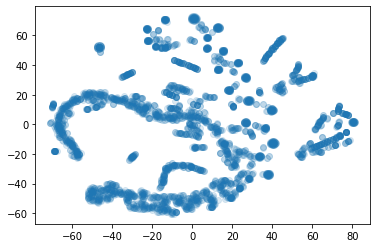

In [117]:
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], alpha=0.15)

plt.show()